#  Прогнозирование заказов такси

## Введение

В данном проекте мы решим задачу в рамках темы "Временные ряды", по проекту "Прогнозирование заказов такси".

Ниже можно найти описание задачи, а также примерный план проекта.

<b>Описание задачи:</b>


Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<b>План работы над проектом:</b>
- Загрузка данных и ресемплирование.
- Анализ данных.
- Обучение моделей.
- Изучение моделей и выбор оптимальной.
- Общий вывод.
- Чек-лист проекта.

<b>Автор проекта:</b>
- Виктория Кускова, 
- студентка Яндекс.Практикума, 2021.


## Подготовка

Выделим импорты всех библиотек, импорт файла с данными и общую информацию по нему в отдельные ячейки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [2]:
#импорт файла с данными
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Видим, что мы успешно загрузили данные, создав индекс по дате. Но теперь нам нужно выполнить ресемплирование по одному часу.

In [4]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


Объем строк уменьшился, это хорошо, значит данные сгруппировались. Видно, что данные у нас с марта по август 2018 года. Посмотрим на первые строки.

In [6]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Данные загружены, теперь посмотрим на них внимательнее и попробуем проанализировать.

## Анализ

### Изучение данных

Посмотрим на то, как меняются данные относительно времени.

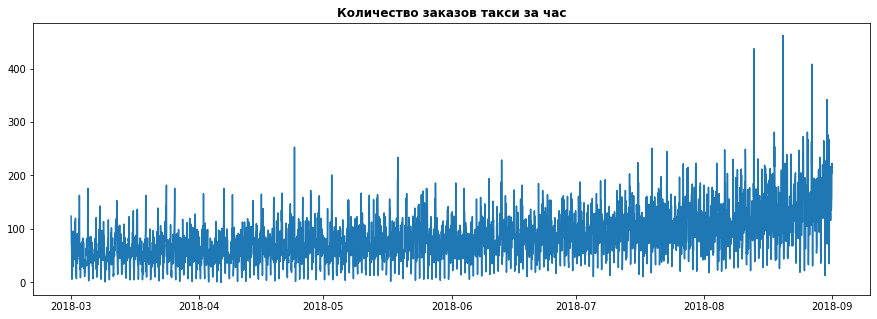

In [7]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(15, 5))
plt.title("Количество заказов такси за час", fontweight='bold', size='large')
plt.plot(df)
plt.show()

Даже по этому графику можно сделать первые выводы:
- количество заказов постепенно растет от марта к августу.
- максимальное количество заказов за 1 час пришлось на август, видим даже несколько выбросов.
- от часа к часу значение колеблитс, поэтому график такой скачащий.

Так как видно, что число заказов в среднем постепенно растет. И в авгуте среднее больше чем в марте. Также и колебаться данные начинают к авгуту сильнее. Поэтому и отклонение скорее всего отличное и меняется со временем. Это говорит о том, что наш ряд <b>нестационарный</b>.

Посмотрим на него внимательнее. Добавим скользящее среднее, где  рамер скольжения - 24 (аналог среднего числа заказов за сутки). Сразу добавим этот столбец, чтобы скользящее среднее считалась без учета текущего часа. 

In [8]:
df['rolling_mean'] = df['num_orders'].shift().rolling(24).mean()

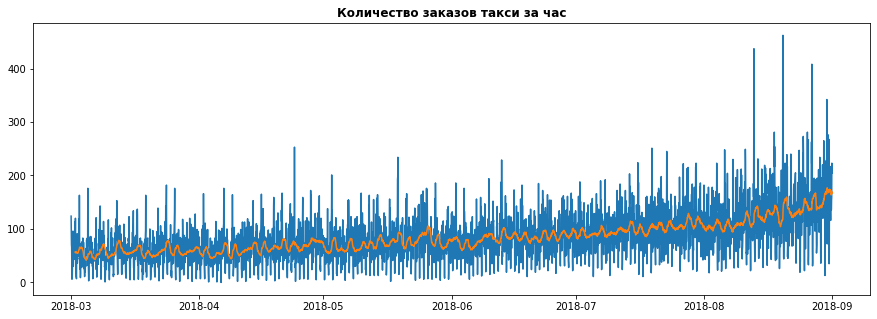

In [9]:
plt.figure(figsize=(15, 5))
plt.title("Количество заказов такси за час", fontweight='bold', size='large')
plt.plot(df)
plt.show()

Да, видим подтверждение наших наблюдений: 
- Среднее число заказов за час явно растет - наблюдается определенные <b>тренд</b>. 
- Но также видим и определенную <b>сезонность</b> отностельно дня ко дню. 

Посмотрим на эти параметры более явно.

In [10]:
decomposed = seasonal_decompose(df['num_orders'])

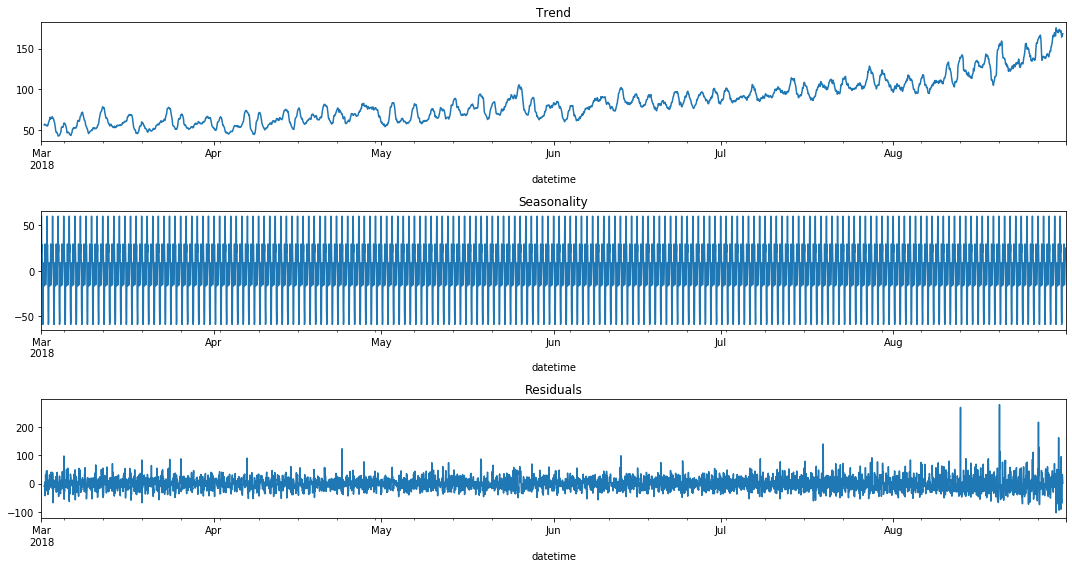

In [11]:
plt.figure(figsize=(15, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Видим на таком большом отрезке времени довольно плотные графики. Но тренд возрастания, определенную сезонность и остаточную сотсаляющую видно. Посмотрим на это на еще и более коротком отрезке - Августе.

In [12]:
decomposed2 = seasonal_decompose(df['2018-08':'2018-08']['num_orders'])

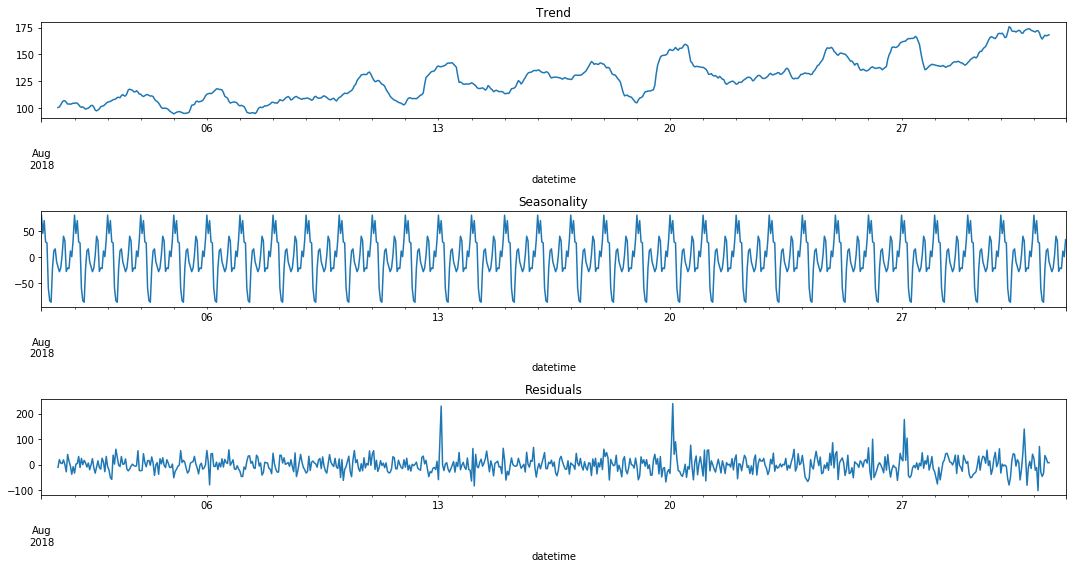

In [13]:
plt.figure(figsize=(15, 8))
plt.subplot(311)
decomposed2.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed2.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed2.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Видим определенно сезонность, которая очень похожа на зависимость от времени суток. Количество цикличных пиков и падений равносильно количеству дней за август.

### Подготовка признаков

Добавим к нашей выборке дополнительные столбцы. Начнем с временных показателей.

In [14]:
ml_df = df.copy()

In [15]:
ml_df['year'] = ml_df.index.year
ml_df['month'] = ml_df.index.month
ml_df['day'] = ml_df.index.day
ml_df['dayofweek'] = ml_df.index.dayofweek
ml_df['hour'] = ml_df.index.hour

In [16]:
ml_df.head()

,num_orders,rolling_mean,year,month,day,dayofweek,hour
datetime,,,,,,,
2018-03-01 00:00:00,124,NaN,2018,3,1,3,0
2018-03-01 01:00:00,85,NaN,2018,3,1,3,1
2018-03-01 02:00:00,71,NaN,2018,3,1,3,2
2018-03-01 03:00:00,66,NaN,2018,3,1,3,3
2018-03-01 04:00:00,43,NaN,2018,3,1,3,4


Теперь добавим отстающие значения.

In [17]:
for lag in range(1, 25):
    ml_df['lag_{}'.format(lag)] = ml_df['num_orders'].shift(lag)

In [18]:
ml_df.head()

,num_orders,rolling_mean,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,2018,3,1,3,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,2018,3,1,3,1,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,2018,3,1,3,2,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,2018,3,1,3,3,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,2018,3,1,3,4,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Отстающие данные тоже добавили.

## Обучение

### Создание выборок

Создадим тестовую и обучающие выборки.

In [19]:
train, test = train_test_split(ml_df, shuffle=False, test_size=0.1)
train = train.dropna()

target_train = train['num_orders']
target_test = test['num_orders']
features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)

In [20]:
train.index.min(), train.index.max(), test.index.min(), test.index.max()

(Timestamp('2018-03-02 00:00:00'),
 Timestamp('2018-08-13 13:00:00'),
 Timestamp('2018-08-13 14:00:00'),
 Timestamp('2018-08-31 23:00:00'))

In [21]:
target_train.shape, target_test.shape, features_train.shape, features_test.shape

((3950,), (442,), (3950, 30), (442, 30))

Разделение прошло успешно, стык на дате 13.08.2018. Размеры выборок 9 к 1. Единственный момент, что из-за смещения по столбцам с отсающими данными - у нас удалились некоторые строки за 01.03, так как они были с пустыми значениями.

### Проверка элементарных моделей

Посмотрим, что будет если предсказывать константой.

In [22]:
pred_median = np.ones(target_test.shape)*target_train.median()
pred_mean = np.ones(target_test.shape)*target_train.mean()

In [23]:
mean_squared_error(target_test, pred_median)**0.5, mean_squared_error(target_test, pred_mean)**0.5

(87.15277582981295, 84.6499381993622)

Теперь посмотрим на оценку RMSE у модели — предсказание предыдущим значением ряда.

In [24]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

In [25]:
mean_squared_error(target_test, pred_previous)**0.5

58.856486242815066

Запомним это значение, а также так как мы помним, что имеет место сезонность в 24 часа, посмотрим на модель сдвига на 24 часа.

In [26]:
pred_previous_24 = features_test['lag_24']

In [27]:
mean_squared_error(target_test, pred_previous_24)**0.5

57.187059099999075

Чуть лучше, но все еще не достигается необходимое значение в 48. Но запомним и это значение. И приступим к более сложным моделям.

| N |       Model                | RMSE на тестовой выборке |  
|---|----------------------------|------------|
| 1 | Median |   87.15  |  
| 2 | Mean |   84.64 | 
| 3 | Previous |   58.85 | 
| 4 | Previous 24 |   57.18 |  

### Линейная регрессия

Посмотрим на модель линейной регресии. Будем использовать TimeSeriesSplit для корретной работы кроссвалидации. 

In [28]:
%%time
warnings.filterwarnings('ignore')
model_lin_reg = LinearRegression()

scores_lin_reg = cross_val_score(
    model_lin_reg, features_train, target_train,
    cv=TimeSeriesSplit(n_splits=5).split(features_train), scoring = 'neg_mean_squared_error')

rmse_lin_reg = sum((-1*scores_lin_reg)**0.5)/5
rmse_lin_reg 

CPU times: user 340 ms, sys: 333 ms, total: 673 ms
Wall time: 604 ms


26.941302874226977

Отлично, необходимая метрика достигнута при обучении! Возможно на тесте все изменится, но пока запомним этот результат и перейдем к другим моделям.

Более сложные модели будем запоминать будем в отдельную таблицу.

| N |       Model                | RMSE |  
|---|----------------------------|------------|
| 1 |LinearRegression |   26.94 |  


### Дерево решений

Переберем параметры через цикл. Так как в кроссвалидации есть риск перемешивания выборок, что нам не нужно

In [29]:
model_decision_tree = DecisionTreeRegressor(random_state=12345)
parameters_decision_tree = { 'max_depth': range(1, 20) }

In [30]:
%%time
grid_search = GridSearchCV(
    estimator = model_decision_tree, param_grid = parameters_decision_tree,
    scoring = 'neg_mean_squared_error', n_jobs = -1,
    cv=TimeSeriesSplit(n_splits=5).split(features_train)
)
grid_search.fit(features_train, target_train)

CPU times: user 3.55 s, sys: 0 ns, total: 3.55 s
Wall time: 3.57 s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f6bbf145d50>,
             error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=12345,
                                             splitter='best'),
             iid='warn', n_jobs=-1, param_grid={'max_depth': range(1, 20)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_m

In [31]:
grid_search.best_params_ , (-1*grid_search.best_score_)**0.5

({'max_depth': 5}, 30.659438978158978)

Кажется дерево решений хуже решает эту задачу, чем линейная регрессия.

| N |       Model                | RMSE |  
|---|----------------------------|------------|
| 1 |LinearRegression |   26.94 |   
| 2 | DecisionTreeRegressor |   30.65 |  

###  Лес решений

Переберем параметры также через цикл. 

In [32]:
model_random_forest = RandomForestRegressor(random_state=12345)
parameters_random_forest = { 'n_estimators': range(1, 21),
                            'max_depth': range(1, 11) }

In [33]:
%%time
grid_search = GridSearchCV(
    estimator = model_random_forest, param_grid = parameters_random_forest,
    scoring = 'neg_mean_squared_error', n_jobs = -1,
    cv=TimeSeriesSplit(n_splits=5).split(features_train)
)
grid_search.fit(features_train, target_train)

CPU times: user 2min 34s, sys: 265 ms, total: 2min 34s
Wall time: 2min 37s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f6bbe66c6d0>,
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False,
                                             random_state=12345, verbose=0,
                                          

In [34]:
grid_search.best_params_ , (-1*grid_search.best_score_)**0.5

({'max_depth': 9, 'n_estimators': 20}, 26.312690595685737)

Отличная метрика! Запомним ее.

| N |       Model                | RMSE |  
|---|----------------------------|------------|
| 1 |LinearRegression |   26.94 |   
| 2 | DecisionTreeRegressor |   30.65 |  
| 3 | RandomForestRegressor |   26.31 | 

### LightGBM

Попробуем решить эту задачу регрессии через библиотеку LightGBM.

In [35]:
model_lgbm = LGBMRegressor(random_state=12345)

parameters = { 'n_estimators': [10, 20, 30],
              'max_depth': [5, 10, 20],
             'learning_rate': [0.1, 1.0]
             }

In [36]:
%%time
grid_search = GridSearchCV(
    estimator = model_lgbm, param_grid = parameters,
    scoring = 'neg_mean_squared_error', n_jobs = -1,
    cv=TimeSeriesSplit(n_splits=5).split(features_train)
)

grid_search.fit(features_train, target_train)

CPU times: user 42.9 s, sys: 352 ms, total: 43.3 s
Wall time: 43.8 s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f6bbe66cd50>,
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=12345,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 1.0], 'max_depth': [5, 10, 20],
                     

In [37]:
grid_search.best_params_ , (-1*grid_search.best_score_)**0.5

({'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 30},
 25.671204463244713)

Метрика еще улучшилась.

| N |       Model                | RMSE |  
|---|----------------------------|------------|
| 1 |LinearRegression |   26.94 |   
| 2 | DecisionTreeRegressor |   30.65 |  
| 3 | RandomForestRegressor |   26.31 | 
| 4 | LGBMRegressor |   25.67 |

### CatBoost

Приступим к регрессии из CatBoost. 

К сожалению, ядро не дало перебрать хоть какие-то гиперпараметры в этой моделе, поэтому тут останавливаемся на базовой, без перебора параметров

In [38]:
model_cat_boost = CatBoostRegressor(random_seed=12345,
                                    loss_function='RMSE')

#parameters_cat_boost = { 'n_estimators': [20, 50]}

In [39]:
%%time
grid_search = GridSearchCV(
    estimator = model_cat_boost, scoring ='neg_mean_squared_error', 
    param_grid = {}, n_jobs = -1,
    cv=TimeSeriesSplit(n_splits=5).split(features_train)
)

grid_search.fit(features_train, target_train, verbose=1000)

0:	learn: 29.2922887	total: 49.4ms	remaining: 49.4s
999:	learn: 3.5571247	total: 13.7s	remaining: 0us
0:	learn: 29.9562776	total: 2.66ms	remaining: 2.66s
999:	learn: 7.0086114	total: 19.3s	remaining: 0us
0:	learn: 31.5668873	total: 5.11ms	remaining: 5.11s
999:	learn: 9.1770846	total: 21.2s	remaining: 0us
0:	learn: 32.9567215	total: 3.45ms	remaining: 3.44s
999:	learn: 10.8749528	total: 26.5s	remaining: 0us
0:	learn: 34.3095200	total: 4.16ms	remaining: 4.15s
999:	learn: 12.2889709	total: 28.3s	remaining: 0us
0:	learn: 38.1294062	total: 3.85ms	remaining: 3.84s
999:	learn: 14.0662859	total: 30.1s	remaining: 0us
CPU times: user 2min 7s, sys: 15 s, total: 2min 22s
Wall time: 2min 30s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f6bbe6343d0>,
             error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7f6bbe578f50>,
             iid='warn', n_jobs=-1, param_grid={}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [40]:
(-1*grid_search.best_score_)**0.5

24.470565227278737

Модель CatBoostRegressor показала себя лучше, чем LGBMRegressor. И относительно этой модели, еще и переобучена меньше.

| N |       Model                | RMSE |  
|---|----------------------------|------------|
| 1 |LinearRegression |   26.94 |   
| 2 | DecisionTreeRegressor |   30.65 |  
| 3 | RandomForestRegressor |   26.31 | 
| 4 | LGBMRegressor |   25.67 |
| 5 | <b>CatBoostRegressor</b> |   24.47 | 


Остановимся на ней как на основной.

## Тестирование

Протестируем модель CatBoostRegressor, на которой и остановились.

In [41]:
%%time
model_cat_boost.fit(features_train, target_train, verbose=1000)

pred_cat_boost = model_cat_boost.predict(features_test)

0:	learn: 38.1294062	total: 4.89ms	remaining: 4.89s
999:	learn: 14.0662859	total: 30.3s	remaining: 0us
CPU times: user 27.7 s, sys: 3.37 s, total: 31 s
Wall time: 33.9 s


In [42]:
mean_squared_error(target_test, pred_cat_boost)**0.5

40.97215225298124

Результат на тесте выше, чем при обучении. Но это меньше 48, поэтому условие задачи и тестирования выполняется. 
Модель прошла тестирование.

Посмотрим теперь какие факторы оказались важны при обучении модели.

In [43]:
model_cat_boost.feature_importances_

array([ 2.57396444,  0.        ,  2.56215612,  0.67270993,  4.15457242,
       16.63423235,  8.07853546,  3.91778969,  3.02315155,  1.3095191 ,
        1.75900304,  1.64350389,  4.04074554,  1.68899347,  1.7802805 ,
        1.94656082,  1.72568675,  2.43202338,  1.99175458,  1.166896  ,
        1.2666396 ,  1.13734237,  3.39097449,  1.65906548,  1.56960794,
        1.71940829,  1.58770221,  1.80965537,  3.03741671, 19.72010853])

Попробуем это визуализировать.

In [44]:
columns = list(features_train.columns)

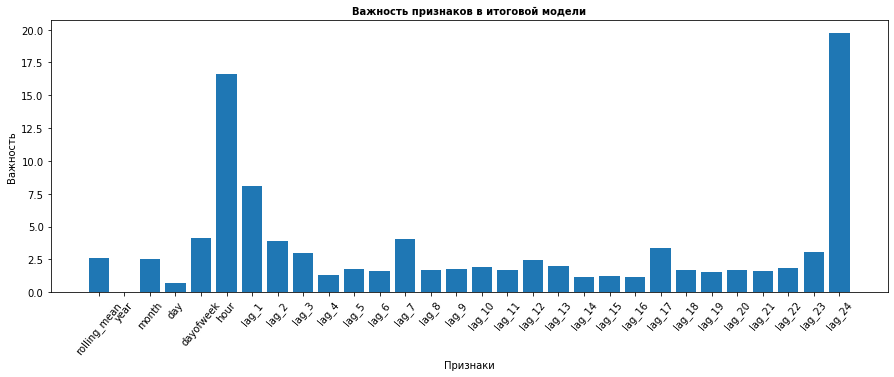

In [45]:
plt.figure(figsize=(15, 5))
plt.title("Важность признаков в итоговой модели", fontweight='bold', size='medium')

plt.ylabel("Важность")
plt.xlabel("Признаки")
plt.xticks(range(len(model_cat_boost.feature_importances_)), columns, rotation=50, size='medium')
plt.bar(
    range(len(model_cat_boost.feature_importances_)),
    model_cat_boost.feature_importances_)
plt.show()

Видим, что факторы, которые внесли наибольший вклад:
- количество заказов 24 часа назад,
- час, временной атрибут,
- количество заказов за прошлый час.

Совсем не важным оказался год. Что логично, так как он одинаковый на всех строках - 2018.

## Вывод

<b>Краткие выводы проекта:</b>
- Данные по заказам такси с марта по август 2018 года.
- На основе графика можно увидеть, что количество заказов постепенно растет от марта к августу.
- Максимальное количество заказов за 1 час пришлось на август, есть даже несколько выбросов.
- Есть определенный тренд: Число заказов в среднем постепенно растет. 
- К примеру, в августе среднее число заказов в 1 час больше чем в марте. Также и колебаться данные начинают к августу сильнее. Поэтому и снандартное отклонение меняется со временем. 
- Это говорит о том, что наш ряд нестационарный.
- Также есть и сезонность, на более узком отрезке видно - она циклично в разрезе суток.

Для предсказания сначала использовались элементарные модели. Они показали следующие результаты, но RMSE у всех больше 48 и не удовлетворяет условию задачи.

| N |       Model                | RMSE на тестовой выборке |  
|---|----------------------------|------------|
| 1 | Median |   87.15  |  
| 2 | Mean |   84.64 | 
| 3 | Previous |   58.85 | 
| 4 | Previous 24 |   57.18 |  

После были использованы более сложные модели, данные перед обучением были насыщены новыми признаками: скользящим среднем по прошлым данным, отстающими данными и временными атрибутами. 
Итоги обучения моделей:

| N |       Model                | RMSE |  
|---|----------------------------|------------|
| 1 | LinearRegression |   26.94 |   
| 2 | DecisionTreeRegressor |   30.65 |  
| 3 | RandomForestRegressor |   26.31 | 
| 4 | LGBMRegressor |   25.67 |
| 5 | <b>CatBoostRegressor</b> |   24.47 | 


- Все модели показали качество при обучении лучше, чем элементарные -  константы  и  сдвиг на предудушее значение и на 24 часа назад.
- Хуже всего себя показала модель DecisionTreeRegressor, RMSE около 31.
- LinearRegression и RandomForestRegressor показали себя похожим образом RMSE около 26.
- Лучше всего себя показали модели LGBMRegressor и CatBoostRegressor (RMSE около 25 и 24), но  у CatBoostRegressor RMSE меньше.  Поэтому остановимся на ней.

При тестировании выбранная модель CatBoostRegressor показала RMSE на тесте 40.97, что меньше 48 и подходит под условие задачи. Хотя определенно видна проблема переобучения.

Видим, что факторы, которые внесли наибольший вклад при обучении модели:
- количество заказов 24 часа назад,
- час, временной атрибут,
- количество заказов за прошлый час.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48